## **DQN MLP**

In [268]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import imageio

from collections import deque
from IPython.display import Video
from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.wrappers.observation import FeatureVectorObservation
from tetris_gymnasium.mappings.rewards import RewardsMapping

In [269]:
from tetris_gymnasium.envs.tetris import RewardsMapping

def make_custom_tetris_env(
    alife=0.01,
    clear_line=50,
    game_over=-5,
    invalid_action=-1,
    report_height=True,
    report_max_height=False,
    report_holes=True,
    report_bumpiness=True,
):

    # Create custom reward map
    custom_map = RewardsMapping(
        alife=alife,
        clear_line=clear_line,
        game_over=game_over,
        invalid_action=invalid_action
    )

    # Initialize env with reward override
    env = gym.make(
        "tetris_gymnasium/Tetris",
        rewards_mapping=custom_map,
        # render_mode="rgb_array"  # Uncomment if needed
    )
    
    # Apply feature observation wrapper
    env = FeatureVectorObservation(
        env,
        report_height=report_height,
        report_max_height=report_max_height,
        report_holes=report_holes,
        report_bumpiness=report_bumpiness
    )
    
    return env

In [270]:
# def make_custom_tetris_env(
#     alife=1,
#     clear_line=50,
#     game_over=-5,
#     invalid_action=-0.1,
#     report_height=True,
#     report_max_height=True,
#     report_holes=True,
#     report_bumpiness=True
# ):

#     # Create custom reward map
#     custom_map = RewardsMapping(
#         alife=alife,
#         clear_line=clear_line,
#         game_over=game_over,
#         invalid_action=invalid_action
#     )

#     # Initialize env with reward override
#     env = gym.make(
#         "tetris_gymnasium/Tetris",
#         rewards_mapping=custom_map,
#         # render_mode="rgb_array"
#     )
    
#     # Apply feature observation wrapper
#     env = FeatureVectorObservation(
#         env,
#         report_height=report_height,
#         report_max_height=report_max_height,
#         report_holes=report_holes,
#         report_bumpiness=report_bumpiness
#     )
    
#     return env

### **Neural Network**

In [271]:
class DQN_MLP(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(DQN_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.out = nn.Linear(128, num_actions)

    def forward(self, x):
        # x shape: [batch_size, input_dim]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.out(x)

### **ReplayBuffer**

In [272]:
class PrioritizedReplayMemory:
    def __init__(self, capacity, device, alpha=0.6):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.position = 0
        self.device = device
        self.alpha = alpha
    
    def push(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.priorities else 1.0
        
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.memory[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
        
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.memory) < batch_size:
            raise ValueError(f"Not enough samples: {len(self.memory)} < {batch_size}")
        
        priorities = np.array(self.priorities, dtype=np.float32)
        probs = priorities ** self.alpha
        probs = probs / (probs.sum() + 1e-8)
        
        indices = np.random.choice(len(self.memory), batch_size, p=probs, replace=False)
        batch = [self.memory[i] for i in indices]
        
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Importance sampling weights
        weights = (len(self.memory) * probs[indices]) ** (-beta)
        weights = weights / (weights.max() + 1e-8)
        
        # Convert to tensors
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)
        weights = torch.tensor(weights, dtype=torch.float32, device=self.device)
        
        return states, actions, rewards, next_states, dones, weights, indices
    
    def update_priorities(self, indices, td_errors, eps=1e-5):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + eps
    
    def __len__(self):
        return len(self.memory)

In [273]:
# class ReplayMemory:
#     def __init__(self, capacity, device):
#         self.memory = deque(maxlen=capacity)
#         self.device = device  # 'cuda' or 'cpu'

#     def push(self, state, action, reward, next_state, done):
#         # Store raw (numpy or list) to save memory instead of storing tensors directly
#         self.memory.append((state, action, reward, next_state, done))

#     def sample(self, batch_size):
#         batch = random.sample(self.memory, batch_size)
#         states, actions, rewards, next_states, dones = zip(*batch)

#         # Convert to tensors and pin memory for faster GPU transfer
#         states = torch.tensor(np.array(states), dtype=torch.float32).pin_memory()
#         next_states = torch.tensor(np.array(next_states), dtype=torch.float32).pin_memory()
#         actions = torch.tensor(actions, dtype=torch.long).pin_memory()
#         rewards = torch.tensor(rewards, dtype=torch.float32).pin_memory()
#         dones = torch.tensor(dones, dtype=torch.float32).pin_memory()

#         # Transfer to GPU asynchronously for speed
#         return (
#             states.to(self.device, non_blocking=True),
#             actions.to(self.device, non_blocking=True),
#             rewards.to(self.device, non_blocking=True),
#             next_states.to(self.device, non_blocking=True),
#             dones.to(self.device, non_blocking=True)
#         )

#     def __len__(self):
#         return len(self.memory)

### **Training**

In [274]:
env = make_custom_tetris_env()
obs, _ = env.reset()

print("Action space:", env.action_space)
print("Initial observation shape:", obs.shape[0])
print("Sample observation:", obs)

Action space: Discrete(8)
Initial observation shape: 12
Sample observation: [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def train_dqn(episodes=2000, batch_size=32, gamma=0.999, lr=0.001, 
               epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=50000,
               target_update=1000, buffer_size=100000):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    env = make_custom_tetris_env()

    obs, _ = env.reset()
    obs_shape = obs.shape[0]
    num_actions = env.action_space.n

    policy_net = DQN_MLP(obs_shape, num_actions).to(device)
    target_net = DQN_MLP(obs_shape, num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = PrioritizedReplayMemory(buffer_size, device=device)

    steps_done = 0
    rewards_history = []
    lines_history = []
    
    # ✅ Beta annealing setup
    beta_start = 0.4
    beta_end = 1.0
    total_steps_estimate = episodes * 15

    for ep in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)

        done = False
        total_shaped_reward = 0
        lines_cleared = 0
        episode_steps = 0  # ✅ Track episode length

        while not done:
            episode_steps += 1  # ✅ Increment counter
            
            # Epsilon decay
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-steps_done / epsilon_decay)
            
            if random.random() < epsilon:
                action = env.action_space.sample()  # CPU
            else:
                s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    action = policy_net(s).argmax(1).item()  # GPU computation

            # ✅ Get raw state first
            next_state, raw_reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            done = terminated or truncated
            
            # features = {
            #     "height1": next_state[0],
            #     "height2": next_state[1],
            #     "height3": next_state[2],
            #     "height4": next_state[3],
            #     "height5": next_state[4],
            #     "height6": next_state[5],
            #     "height7": next_state[6],
            #     "height8": next_state[7],
            #     "height9": next_state[8],
            #     "height10": next_state[9],
            #     "holes": next_state[10],
            #     "bumpiness": next_state[11],
            # }
            
            # print(features)

            # aggregate_height = sum(next_state[0:10])
            
            # print(aggregate_height)
            
            shaping = (
                0.001 * episode_steps
                # -0.1 * aggregate_height +   # 10 to 100
                # -1.5 * next_state[10] +     # Holes 0 to 50
                # -0.01 * next_state[11]       # Bumpiness 0 to 50
            )
            
            shaped_reward = raw_reward + shaping

            # CPU operation
            memory.push(state, action, shaped_reward, next_state, done)
            state = next_state

            total_shaped_reward += shaped_reward
            if raw_reward == 50:
                lines_cleared += 1

            steps_done += 1

            # Learn if enough samples
            if len(memory) > batch_size:
                # ✅ Anneal beta
                beta = min(beta_end, beta_start + (beta_end - beta_start) * (steps_done / total_steps_estimate))
                
                # CPU priority calculations, then CPU→GPU transfer
                states, actions, rewards, next_states, dones, weights, indices = memory.sample(batch_size, beta)

                # ✅ All GPU operations from here
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    next_actions = policy_net(next_states).argmax(1)
                    next_q_values = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    targets = rewards + gamma * next_q_values * (1 - dones)

                # GPU: loss calculation and backprop
                loss = (weights * (q_values - targets).pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()  # GPU backprop
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
                optimizer.step()  # GPU weight updates

                # ✅ GPU→CPU transfer only for priority updates
                td_errors = (q_values - targets).detach().cpu().numpy()
                memory.update_priorities(indices, td_errors)  # CPU

            # Update target network (GPU to GPU copy)
            if steps_done % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        rewards_history.append(total_shaped_reward)
        lines_history.append(lines_cleared)
        
        # ✅ Better logging with breakdown
        if ep % 50 == 0:
            base_rewards = episode_steps * 0.1 + lines_cleared * 50 - 5
            shaping_contrib = total_shaped_reward - base_rewards
            
            print(f"Episode {ep}, Steps: {episode_steps}, Lines: {lines_cleared}, "
                  f"Reward: {total_shaped_reward:.2f} (base: {base_rewards:.1f}, shaping: {shaping:.3f}), "
                  f"Epsilon: {epsilon:.3f}")
        
        # ✅ Summary every 100 episodes
        if ep % 100 == 0 and ep > 0:
            recent_rewards = rewards_history[-100:]
            recent_lines = sum(lines_history[-100:])
            print(f"\n📊 Last 100 Episodes Summary:")
            print(f"  Avg Reward: {np.mean(recent_rewards):.2f}")
            print(f"  Best Reward: {np.max(recent_rewards):.2f}")
            print(f"  Worst Reward: {np.min(recent_rewards):.2f}")
            print(f"  Total Lines: {recent_lines}")
            print(f"  Avg Lines/Episode: {recent_lines/100:.2f}\n")

    env.close()
    return policy_net, rewards_history, lines_history

In [276]:
# def train_dqn(episodes=10000, batch_size=32, gamma=0.999, lr=0.001, 
#                epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=500000,
#                target_update=1000, buffer_size=100000):

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     env = make_custom_tetris_env()

#     obs, _ = env.reset()
#     obs_shape = obs.shape[0]
#     num_actions = env.action_space.n

#     policy_net = DQN_MLP(obs_shape, num_actions).to(device)
#     target_net = DQN_MLP(obs_shape, num_actions).to(device)
#     target_net.load_state_dict(policy_net.state_dict())

#     optimizer = optim.Adam(policy_net.parameters(), lr=lr)
#     memory = PrioritizedReplayMemory(buffer_size, device=device)

#     steps_done = 0
#     epsilon = epsilon_start
#     rewards_history = []
#     lines_history = []
#     alive_history = []

#     for ep in range(episodes):
#         state, _ = env.reset()
#         state = np.array(state, dtype=np.float32) / 7.0

#         done = False
#         total_shaped_reward = 0
#         total_lines_reward = 0
#         total_alive_reward = 0

#         while not done:
#             # Epsilon-greedy action
#             epsilon = max(epsilon_end, epsilon_end + (epsilon_start - epsilon_end) * np.exp(-steps_done / epsilon_decay))
#             if random.random() < epsilon:
#                 action = env.action_space.sample()
#             else:
#                 s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
#                 with torch.no_grad():
#                     action = policy_net(s).argmax(1).item()

#             next_state, raw_reward, terminated, truncated, _ = env.step(action)
#             next_state = np.array(next_state, dtype=np.float32) / 7.0
#             done = terminated or truncated

#             # Reward shaping
#             shaping = (
#                 -0.1 * next_state[0]  # max_height
#                 -0.3 * next_state[1]  # holes
#                 -0.2 * next_state[2]  # bumpiness
#             )
#             shaped_reward = raw_reward + shaping

#             # Push to PER memory
#             memory.push(state, action, shaped_reward, next_state, done)
#             state = next_state

#             total_shaped_reward += shaped_reward
#             if raw_reward == 50:
#                 total_lines_reward += 1
#             elif raw_reward == 0.1:
#                 total_alive_reward += raw_reward

#             steps_done += 1

#             # Learn if enough samples
#             if len(memory) > batch_size:
#                 states, actions, rewards, next_states, dones, weights, indices = memory.sample(batch_size)

#                 # Compute Q values
#                 q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

#                 # **DDQN target calculation**
#                 with torch.no_grad():
#                     next_actions = policy_net(next_states).argmax(1)
#                     next_q_values = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
#                     targets = rewards + gamma * next_q_values * (1 - dones)

#                 # TD error weighted loss
#                 loss = (weights * (q_values - targets).pow(2)).mean()

#                 optimizer.zero_grad()
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
#                 optimizer.step()

#                 # Update priorities in memory
#                 td_errors = (q_values - targets).detach().cpu().numpy()
#                 memory.update_priorities(indices, td_errors)

#             # Update target network
#             if steps_done % target_update == 0:
#                 target_net.load_state_dict(policy_net.state_dict())

#         # Store episode rewards
#         rewards_history.append(total_shaped_reward)
#         lines_history.append(total_lines_reward)
#         alive_history.append(total_alive_reward)
        
#         if ep % 50 == 0:
#             print(f"Episode {ep}, Total Shaped Reward: {total_shaped_reward:.2f}, Lines: {total_lines_reward:.2f}, Alive: {total_alive_reward:.2f}, Epsilon: {epsilon:.3f}")

#     env.close()
#     return policy_net, rewards_history

In [277]:
# def train_dqn(episodes=10000, batch_size=32, gamma=0.99, lr=1e-4, 
#               epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=500000,
#               target_update=1000, buffer_size=100000):
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     env = make_custom_tetris_env()
    
#     obs, _ = env.reset()
#     obs_shape = obs.shape[0]
#     num_actions = env.action_space.n

#     policy_net = DQN_MLP(obs_shape, num_actions).to(device)
#     target_net = DQN_MLP(obs_shape, num_actions).to(device)
#     target_net.load_state_dict(policy_net.state_dict())
    
#     optimizer = optim.Adam(policy_net.parameters(), lr=lr)
#     memory = ReplayMemory(buffer_size, device=device)

#     steps_done = 0
#     epsilon = epsilon_start
#     rewards_history = []  # Total shaped reward per episode
#     lines_history = []    # Lines reward per episode
#     alive_history = []    # Alive reward per episode

#     for ep in range(episodes):
#         state, _ = env.reset()
#         state = np.array(state, dtype=np.float32) / 7.0

#         done = False
#         total_shaped_reward = 0
#         total_lines_reward = 0
#         total_alive_reward = 0

#         while not done:
#             # Epsilon-greedy action (with safeguard to not go below epsilon_end)
#             epsilon = max(epsilon_end, epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1.0 * steps_done / epsilon_decay))

#             if random.random() < epsilon:
#                 action = env.action_space.sample()
#             else:
#                 s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
#                 with torch.no_grad():
#                     action = policy_net(s).argmax(1).item()

#             next_state, raw_reward, terminated, truncated, _ = env.step(action)
#             next_state = np.array(next_state, dtype=np.float32) / 7.0
#             done = terminated or truncated
            
#             # features = {
#             #     "max_height": next_state[0],
#             #     "holes": next_state[1],
#             #     "bumpiness": next_state[2],
#             # }
            
#             # print(features)
            
#             # features = {
#             #     "height": next_state[0],
#             #     "max_height": next_state[1],
#             #     "holes": next_state[2],
#             #     "bumpiness": next_state[3],
#             # }
            
#             shaping = (
#                 -0.1 * next_state[0]     # discourage high max height
#                 -0.3 * next_state[1]     # discourage holes
#                 -0.2 * next_state[2]     # discourage bumpiness
#             )
            
#             shaped_reward = raw_reward + shaping

#             # Push to memory
#             memory.push(state, action, shaped_reward, next_state, done)
#             state = next_state
            
#             # Accumulate rewards for tracking
#             total_shaped_reward += shaped_reward
#             if raw_reward == 50:
#                 total_lines_reward += raw_reward / 50
#             elif raw_reward == 0.1:
#                 total_alive_reward += raw_reward
                
#             steps_done += 1

#             # Learn
#             if len(memory) > batch_size:
#                 states, actions, rewards, next_states, dones = memory.sample(batch_size)

#                 states, next_states = states.to(device), next_states.to(device)
#                 actions, rewards, dones = actions.to(device), rewards.to(device), dones.to(device)

#                 q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
#                 next_q_values = target_net(next_states).max(1)[0]
#                 targets = rewards + gamma * next_q_values * (1 - dones)

#                 loss = nn.MSELoss()(q_values, targets)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 # Gradient clipping for stability
#                 torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
#                 optimizer.step()

#             # Update target network (every target_update steps)
#             if steps_done % target_update == 0:
#                 target_net.load_state_dict(policy_net.state_dict())

#         # Store episode rewards
#         rewards_history.append(total_shaped_reward)
#         lines_history.append(total_lines_reward)
#         alive_history.append(total_alive_reward)
        
#         # Print every 50 episodes
#         # if ep % 50 == 0:
#         print(f"Episode {ep}, Total Shaped Reward: {total_shaped_reward:.2f}, Lines: {total_lines_reward:.2f}, Alive: {total_alive_reward:.2f}, Epsilon: {epsilon:.3f}")

#     env.close()
#     return policy_net, rewards_history

In [278]:
# def train_dqn(episodes=episodes, batch_size=batch_size, gamma=gamma, lr=lr, 
#               epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay, 
#               target_update=target_update, buffer_size=buffer_size):
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     env = make_custom_tetris_env()
    
#     obs, _ = env.reset()
#     obs_shape = obs.shape[0]
#     num_actions = env.action_space.n

#     policy_net = DQN_MLP(obs_shape, num_actions).to(device)
#     target_net = DQN_MLP(obs_shape, num_actions).to(device)
#     target_net.load_state_dict(policy_net.state_dict())
    
#     optimizer = optim.Adam(policy_net.parameters(), lr=lr)
#     memory = ReplayMemory(buffer_size, device=device)

#     steps_done = 0
#     epsilon = epsilon_start
#     rewards_history = []

#     for ep in range(episodes):
#         state, _ = env.reset()
#         state = np.array(state, dtype=np.float32) / 7.0

#         done = False
#         total_reward_line = 0
#         total_reward_alife = 0

#         while not done:
#             # Epsilon-greedy action
#             epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1.0 * steps_done / epsilon_decay)

#             if random.random() < epsilon:
#                 action = env.action_space.sample()
#             else:
#                 s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
#                 with torch.no_grad():
#                     action = policy_net(s).argmax(1).item()

#             next_state, reward, terminated, truncated, _ = env.step(action)
#             next_state = np.array(next_state, dtype=np.float32) / 7.0
#             done = terminated or truncated
            
#             features = {
#                 "height": next_state[0],
#                 "max_height": next_state[1],
#                 "holes": next_state[2],
#                 "bumpiness": next_state[3],
#             }
            
#             norm_state = next_state

#             # Heuristic shaping reward (small influence)
#             shaping = (
#                 -0.5 * norm_state[0]     # discourage stacking too high of all columns
#                 -1.5 * norm_state[1]     # discourage stacking too high of one column
#                 -1.0 * norm_state[2]     # discourage creating holes
#                 -1.5 * norm_state[3]     # discourage bumpiness
#             )
            
#             raw_reward = reward  # environment’s own reward (e.g. 50, -10, 0.1)

#             # Combine with base reward
#             reward = raw_reward + shaping
            
#             if raw_reward == 50:
#                 shaped_reward = 20
#             elif raw_reward == -5:
#                 shaped_reward = 10
#             else:
#                 shaped_reward = reward

#             memory.push(state, action, shaped_reward, next_state, done)
#             state = next_state
            
#             if reward != 0.1:
#                 total_reward_line += reward
#             else:
#                 total_reward_alife += reward
                
#             steps_done += 1

#             # Learn
#             if len(memory) > batch_size:
#                 states, actions, rewards, next_states, dones = memory.sample(batch_size)

#                 states, next_states = states.to(device), next_states.to(device)
#                 actions, rewards, dones = actions.to(device), rewards.to(device), dones.to(device)

#                 q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
#                 next_q_values = target_net(next_states).max(1)[0]
#                 targets = rewards + gamma * next_q_values * (1 - dones)

#                 loss = nn.MSELoss()(q_values, targets)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             # Update target network
#             if steps_done % target_update == 0:
#                 target_net.load_state_dict(policy_net.state_dict())

#         rewards_history.append(total_reward_line)
#         # if ep % 50 == 0:
#         print(f"Episode {ep}, Total Reward: {total_reward_line:.2f}, Total Living Reward: {total_reward_alife:.2f}, Epsilon: {epsilon:.2f}")

#     env.close()
#     return policy_net, rewards_history

In [279]:
q_net, history, lines = train_dqn()

Using device: cuda
Episode 0, Steps: 72, Lines: 0, Reward: -2.28 (base: 2.2, shaping: 0.072), Epsilon: 0.999
Episode 50, Steps: 103, Lines: 0, Reward: 0.49 (base: 5.3, shaping: 0.103), Epsilon: 0.948
Episode 100, Steps: 40, Lines: 0, Reward: -4.09 (base: -1.0, shaping: 0.040), Epsilon: 0.904

📊 Last 100 Episodes Summary:
  Avg Reward: -3.14
  Best Reward: 1.92
  Worst Reward: -4.76
  Total Lines: 0
  Avg Lines/Episode: 0.00

Episode 150, Steps: 43, Lines: 0, Reward: -3.96 (base: -0.7, shaping: 0.043), Epsilon: 0.865
Episode 200, Steps: 47, Lines: 0, Reward: -3.77 (base: -0.3, shaping: 0.047), Epsilon: 0.832

📊 Last 100 Episodes Summary:
  Avg Reward: -3.66
  Best Reward: -0.86
  Worst Reward: -4.75
  Total Lines: 0
  Avg Lines/Episode: 0.00

Episode 250, Steps: 30, Lines: 0, Reward: -4.43 (base: -2.0, shaping: 0.030), Epsilon: 0.804
Episode 300, Steps: 27, Lines: 0, Reward: -4.54 (base: -2.3, shaping: 0.027), Epsilon: 0.778

📊 Last 100 Episodes Summary:
  Avg Reward: -4.12
  Best Rewar

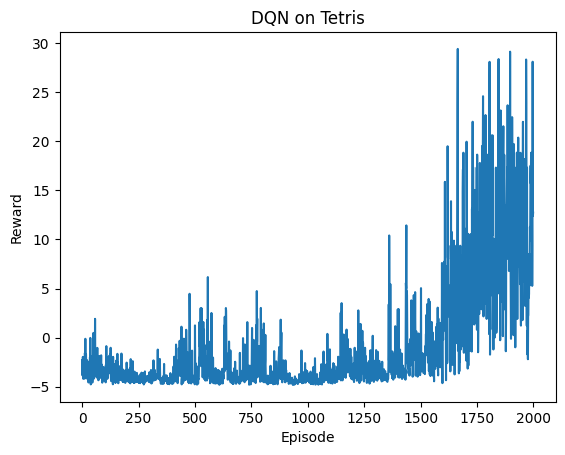

In [280]:
plt.plot(history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on Tetris")
plt.show()

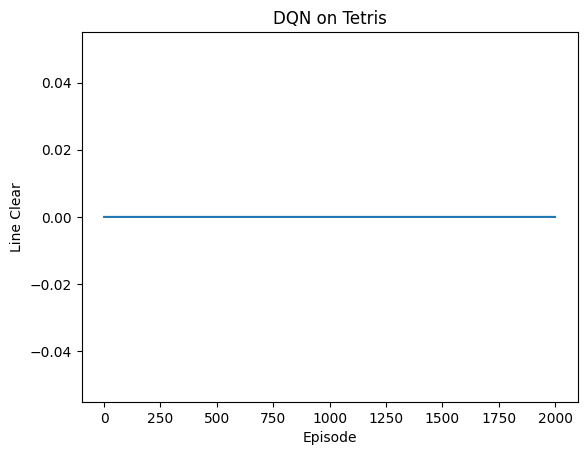

In [281]:
plt.plot(lines)
plt.xlabel("Episode")
plt.ylabel("Line Clear")
plt.title("DQN on Tetris")
plt.show()

In [282]:
def make_custom_tetris_env(
    alife=0.1,
    clear_line=50,
    game_over=-5,
    invalid_action=-0.1,
    report_height=True,
    report_max_height=False,
    report_holes=True,
    report_bumpiness=True
):
    """
    Creates a customized Tetris environment with a modified reward mapping
    and FeatureVectorObservation enabled.
    """
    # ✅ Create custom reward map
    custom_map = RewardsMapping(
        alife=alife,
        clear_line=clear_line,
        game_over=game_over,
        invalid_action=invalid_action
    )

    # ✅ Initialize env with reward override
    env = gym.make(
        "tetris_gymnasium/Tetris",
        rewards_mapping=custom_map,
        render_mode="rgb_array"
    )
    
    # ✅ Apply feature observation wrapper
    env = FeatureVectorObservation(
        env,
        report_height=report_height,
        report_max_height=report_max_height,
        report_holes=report_holes,
        report_bumpiness=report_bumpiness
    )
    
    return env

In [287]:
device = next(q_net.parameters()).device  

env = make_custom_tetris_env()
video_path = "tetris_dqn.mp4"
writer = imageio.get_writer(video_path, fps=30)

for ep in range(100):
    state, _ = env.reset()
    done = False
    while not done:
        # # ✅ Extract feature vector from dict
        # if isinstance(state, dict) and "feature_vector" in state:
        #     state = state["feature_vector"]

        state_tensor = np.array(state, dtype=np.float32) / 7
        state_tensor = torch.tensor(state_tensor, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_net(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if isinstance(next_state, dict) and "feature_vector" in next_state:
            next_state = next_state["feature_vector"]

        state = next_state

        frame = env.render()
        writer.append_data(np.asarray(frame))

writer.close()
env.close()
print(f"Video saved to {video_path}")  

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (340, 240) to (352, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to tetris_dqn.mp4


In [288]:
Video("tetris_dqn.mp4", embed=True)

## **DQN CNN**

In [285]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN_CNN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(DQN_CNN, self).__init__()

        # Example input: (2, 24, 18)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)  # Output around (32, 5, 4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Compute flattened size dynamically (24x18 isn't a power of 2, so we calculate)
        self.flatten_size = None  # We will set this after seeing a sample through conv layers

        self.fc1 = nn.Linear(64 * 2 * 1, 512)  # Temporary numbers, will adjust dynamically
        self.out = nn.Linear(512, num_actions)

    def forward(self, x):
        # x shape: [batch_size, channels, H, W]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            # Update FC layers dynamically
            self.fc1 = nn.Linear(self.flatten_size, 512).to(x.device)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)

In [286]:
# class TetrisObsWrapper(gym.ObservationWrapper):
#     def __init__(self, env):
#         super().__init__(env)

#         # Define final observation space (4 channels, 24x18)
#         self.observation_space = gym.spaces.Box(
#             low=0,
#             high=1,
#             shape=(4, 24, 18),
#             dtype=np.float32,
#         )

#     def observation(self, obs):
#         board = obs["board"].astype(np.float32) / 9.0
#         mask = obs["active_tetromino_mask"].astype(np.float32)
#         holder = obs["holder"].astype(np.float32) / 9.0
#         queue = obs["queue"].astype(np.float32) / 9.0

#         # pad holder to (24, 18)
#         holder_padded = np.zeros((24, 18), dtype=np.float32)
#         holder_padded[:holder.shape[0], :holder.shape[1]] = holder

#         # pad or crop queue safely to fit (24, 18)
#         queue_padded = np.zeros((24, 18), dtype=np.float32)
#         h, w = queue.shape
#         queue_padded[:min(4, h), :min(18, w)] = queue[:min(4, h), :min(18, w)]

#         # stack all channels
#         stacked = np.stack([board, mask, holder_padded, queue_padded], axis=0)
#         return stacked